[I 2025-03-10 19:57:22,326] A new study created in memory with name: no-name-785b7017-dbc9-4bc3-a1b5-9e3630b0b657
[I 2025-03-10 19:57:24,869] Trial 0 finished with value: 0.9791991069620686 and parameters: {'n_estimators': 510, 'max_depth': 5, 'learning_rate': 0.07763631706701321, 'subsample': 0.7424715293791595, 'colsample_bytree': 0.7677606191893448, 'gamma': 0.1531538190512812, 'reg_alpha': 1.3904952611101709, 'reg_lambda': 1.382810873775183}. Best is trial 0 with value: 0.9791991069620686.
[I 2025-03-10 19:57:26,984] Trial 1 finished with value: 0.9755505417162199 and parameters: {'n_estimators': 536, 'max_depth': 5, 'learning_rate': 0.07257324098503087, 'subsample': 0.8035995671127201, 'colsample_bytree': 0.795298648689722, 'gamma': 0.28962922415392484, 'reg_alpha': 0.9703502117848847, 'reg_lambda': 0.9256770643802418}. Best is trial 0 with value: 0.9791991069620686.
[I 2025-03-10 19:57:29,324] Trial 2 finished with value: 0.9740361949455772 and parameters: {'n_estimators': 544, '

[I 2025-03-10 19:58:22,593] Trial 21 finished with value: 0.9830377603388092 and parameters: {'n_estimators': 491, 'max_depth': 5, 'learning_rate': 0.08819605477275684, 'subsample': 0.7560417262506014, 'colsample_bytree': 0.8673653102954346, 'gamma': 0.0755511849291779, 'reg_alpha': 1.073989771379564, 'reg_lambda': 0.8376513256330318}. Best is trial 18 with value: 0.9838375257908213.
[I 2025-03-10 19:58:26,881] Trial 22 finished with value: 0.9841240019052411 and parameters: {'n_estimators': 491, 'max_depth': 5, 'learning_rate': 0.09828682621372553, 'subsample': 0.7494334973752903, 'colsample_bytree': 0.8810394492499392, 'gamma': 0.06509247276860297, 'reg_alpha': 1.0901083009060089, 'reg_lambda': 0.6294189459021688}. Best is trial 22 with value: 0.9841240019052411.
[I 2025-03-10 19:58:31,130] Trial 23 finished with value: 0.9856909736625832 and parameters: {'n_estimators': 504, 'max_depth': 5, 'learning_rate': 0.0996432455091736, 'subsample': 0.7522763186195287, 'colsample_bytree': 0.8


 Mejores hiperparámetros encontrados:
 {'n_estimators': 520, 'max_depth': 5, 'learning_rate': 0.09967787501548325, 'subsample': 0.7831340192834264, 'colsample_bytree': 0.8971140450988209, 'gamma': 0.013473933415560075, 'reg_alpha': 0.900012432370921, 'reg_lambda': 0.5683957654703357}

 Evaluación en Test Set:
MSE: 0.0277 | R²: 0.9880


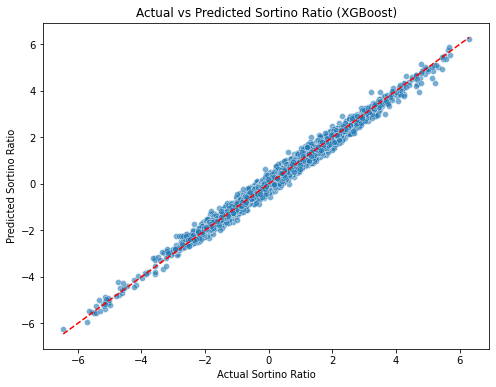

In [13]:
import optuna
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Cargar dataset
file_path = "sampled_data.csv"
df = pd.read_csv(file_path, low_memory=False)

# Preprocesamiento de datos
df = df.drop(columns=['Unnamed: 0', 'Date', 'Portfolio_Returns'])
X = df.drop(columns=['Sortino_Ratio'])
y = df['Sortino_Ratio']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en Train, Validation y Test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 450, 550),
        'max_depth': trial.suggest_int('max_depth', 3, 5),  # Reducimos la profundidad
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  # Aprendizaje más lento
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'gamma': trial.suggest_float('gamma', 0.01, 0.5),  # Evita divisiones innecesarias
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 1.5),  # Regularización L1 más fuerte
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 1.5)  # Regularización L2 más fuerte
    }

    model = xgb.XGBRegressor(**params, objective='reg:squarederror', eval_metric="rmse")
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    return scores.mean()  

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Obtener mejores hiperparámetros
best_params = study.best_params
print("\n Mejores hiperparámetros encontrados:\n", best_params)

best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"\n Evaluación en Test Set:\nMSE: {mse:.4f} | R²: {r2:.4f}")

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results_df["Actual"], y=results_df["Predicted"], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sortino Ratio")
plt.ylabel("Predicted Sortino Ratio")
plt.title("Actual vs Predicted Sortino Ratio (XGBoost)")
plt.show()


In [14]:
# Implementación del mejor modelo XGBoost optimizado
xgb_model = xgb.XGBRegressor(
    n_estimators=520, 
    max_depth=5, 
    learning_rate=0.09967787501548325,
    subsample=0.7831340192834264,
    colsample_bytree=0.89,
    gamma=0.013473933415560075,
    reg_alpha=0.900012432370921,
    reg_lambda=0.5683957654703357,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train)

preds = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("\n Evaluación Final del Modelo XGBoost Optimizado:")
print(f"MSE: {mse:.4f} | R²: {r2:.4f}")



 Evaluación Final del Modelo XGBoost Optimizado:
MSE: 0.0277 | R²: 0.9880


In [15]:
import pickle

with open("xgboost_optimized.pkl", "wb") as file: 
    pickle.dump(xgb_model,file)